In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp



def load_data(base_dir, sample_n=50):
    all_data = []
    tickers_seen = set()

    for root, _, files in os.walk(base_dir):
        np.random.shuffle(files)
        for file in files:
            if file.endswith('.csv'):
                path = os.path.join(root, file)
                try:
                    # ticker z nazwy pliku
                    ticker = os.path.splitext(file)[0]
                    if ticker in tickers_seen:
                        continue

                    # wczytanie danych zgodnie z nowym formatem
                    df = pd.read_csv(path, skiprows=2, header=None,
                                     names=["Date", "Close", "High", "Low", "Open", "Volume"],
                                     usecols=["Date", "Close"])
                    df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m-%d", errors="coerce")
                    df = df.dropna(subset=["Date", "Close"])

                    if df.shape[0] > 100:
                        df["TICKER"] = ticker
                        all_data.append(df)
                        tickers_seen.add(ticker)

                        if len(tickers_seen) >= sample_n:
                            break
                except Exception:
                    continue
        if len(tickers_seen) >= sample_n:
            break

    if not all_data:
        raise Exception("Brak danych")

    return pd.concat(all_data, ignore_index=True)


def prepare_pivot(df, start_year=2020, end_year=2025, max_nan_percent=5.0):
    df = df[(df["Date"].dt.year >= start_year) & (df["Date"].dt.year <= end_year)]
    pivot = df.pivot(index="Date", columns="TICKER", values="Close").sort_index()
    pivot = pivot[pivot.index.weekday < 5]  # usuń weekendy
    nans = pivot.isna().sum() / len(pivot) * 100
    good_tickers = nans[nans <= max_nan_percent].index.tolist()
    pivot = pivot[good_tickers].fillna(method="ffill").fillna(method="bfill")
    return pivot




def markowitz_portfolio(mean_returns, cov_matrix, target_return=0.001):
    mean_returns = np.array(mean_returns)
    cov_matrix = np.array(cov_matrix)
    n = len(mean_returns)
    w = cp.Variable(n) #wektor wag aktywów
    objective = cp.Minimize(cp.quad_form(w, cp.psd_wrap(cov_matrix))) #cel 
    #ograniczenia
    constraints = [
        cp.sum(w) == 1,
        w >= 0,
        w <= 0.1,
        mean_returns @ w >= target_return
    ]
    prob = cp.Problem(objective, constraints) #problem
    prob.solve(solver=cp.OSQP) #rozwiązanie
    return w.value

def rolling_markowitz(pivoted_prices, window_days=60, fee_rate=0.001, rebalance_period=5, target_return=0.001):
    returns = pivoted_prices.pct_change().dropna()
    returns_test = returns[returns.index.year == 2025]
    dates = returns_test.index
    capital, costs = [1.0], 0.0
    prev_weights = pd.Series(1.0 / pivoted_prices.shape[1], index=pivoted_prices.columns)

    for start in range(0, len(dates), rebalance_period):
        end = min(start + rebalance_period, len(dates))
        period_returns = returns_test.iloc[start:end]

    
        if start > 0:
            date_prev = dates[start - rebalance_period]
            date_curr = dates[start]

            # zmiana cen
            prices_prev = pivoted_prices.loc[date_prev]
            prices_curr = pivoted_prices.loc[date_curr]
            rel_returns = prices_curr / prices_prev

            # aktualizacja wag
            prev_weights = prev_weights * rel_returns
            prev_weights = prev_weights / prev_weights.sum()

            # dane do optymalizacji
            data = returns.loc[:date_curr]
            mean_returns = data.tail(window_days).mean()
            cov_matrix = data.tail(window_days).cov()
            new_weights = markowitz_portfolio(mean_returns, cov_matrix, target_return)

            # koszty transakcyjne
            diff = np.abs(new_weights - prev_weights.values)
            if np.any(diff > 0.005):
                cost = fee_rate * diff.sum() * capital[-1]
                costs += cost
                prev_weights = pd.Series(new_weights, index=pivoted_prices.columns)

                week_number = (start // rebalance_period) + 1
                print(f"Tydzień {week_number}: Kapital={capital[-1] - cost:.4f}, Koszt zmiany={cost:.6f}")
                print(f"Po aktualizacji ({dates[start].date()}):")
                print(prev_weights[prev_weights > 0.0001].sort_values(ascending=False).round(4))
                print("-" * 50)
            else:
                cost = 0.0
        else:
            cost = 0.0  # brak kosztów w pierwszym tygodniu

        # wzrost kapitału
        growth = (period_returns * prev_weights).sum(axis=1).add(1).prod()
        capital.append(capital[-1] * growth - cost)

    return pd.Series(capital, index=[dates[0]] + list(dates[::rebalance_period])), costs


def rolling_equal(pivoted_prices, rebalance_period=5, fee_rate=0.001):
    returns = pivoted_prices.pct_change().dropna()
    returns_test = returns[returns.index.year == 2025]
    dates = returns_test.index
    capital_timeline = []
    capital = 1.0

    
    weights = pd.Series(1.0 / pivoted_prices.shape[1], index=pivoted_prices.columns)

    start_date = dates[0]
    start_prices = pivoted_prices.loc[start_date]
    shares = (weights * capital) / start_prices

    for date in dates:
        prices_today = pivoted_prices.loc[date]
        portfolio_value = np.sum(shares * prices_today)
        capital_timeline.append((date, portfolio_value))

    capital_series = pd.Series(dict(capital_timeline))
    return capital_series, 0.0  # brak kosztów

def calculate_portfolio_stats(capital_series):
  
    # CAGR, Sharpe Ratio, Max Drawdown.
    
    returns = capital_series.pct_change().dropna()

    #sredni zwrot
    mean_return=returns.mean()* 252

    # CAGR
    start_value = capital_series.iloc[0]
    end_value = capital_series.iloc[-1]
    n_years = (capital_series.index[-1] - capital_series.index[0]).days / 365.25
    annualized_return = (end_value / start_value) ** (1 / n_years) - 1

    # volatility
    std_dev = returns.std()
    annualized_volatility = std_dev * np.sqrt(252)

    # Sharpe Ratio 
    sharpe_ratio = (returns.mean() * 252) / annualized_volatility

    # Max Drawdown
    cum_returns = (1 + returns).cumprod()
    peak = cum_returns.cummax()
    drawdown = (cum_returns - peak) / peak
    max_drawdown = drawdown.min()

    return {
        "Zwrot roczny (CAGR)": annualized_return,
        "sredni zwrot": mean_return,
        "Zmienność roczna": annualized_volatility,
        "Sharpe Ratio": sharpe_ratio,
        "Max Drawdown": max_drawdown
    }



C:\Users\Basia\AppData\Local\Temp\ipykernel_14044\2792854831.py:55: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  pivot = pivot[good_tickers].fillna(method="ffill").fillna(method="bfill")


Tydzień 2: Kapital=1.0127, Koszt zmiany=0.001830
Po aktualizacji (2025-01-08):
TICKER
1COV.DE       0.1000
SONDA.SN      0.0840
GBPUSDX       0.0635
BCI.SN        0.0566
CEZ.PR        0.0515
               ...  
NOVO-B.CO     0.0015
REY.MI        0.0014
DOGE-USD      0.0013
ELEKTRA.MX    0.0003
ATO.PA        0.0001
Length: 61, dtype: float64
--------------------------------------------------
Tydzień 3: Kapital=1.0081, Koszt zmiany=0.001273
Po aktualizacji (2025-01-15):
TICKER
INRX          0.1000
CADX          0.0888
1COV.DE       0.0677
EURGBPX       0.0636
TRYX          0.0618
AEL.JO        0.0357
CGE.SN        0.0337
BIMAS.IS      0.0314
Z74.SI        0.0311
EBS.VI        0.0294
CRM.US        0.0260
GMG.AX        0.0245
KCF           0.0224
KAREL.IS      0.0211
TPG.AX        0.0192
BS6.SI        0.0186
RWE.DE        0.0183
PSPN.SW       0.0182
OJF           0.0168
MDWD          0.0166
NKE           0.0166
SONDA.SN      0.0164
MRVE3.SA      0.0149
TERRA13.MX    0.0145
DIS           0

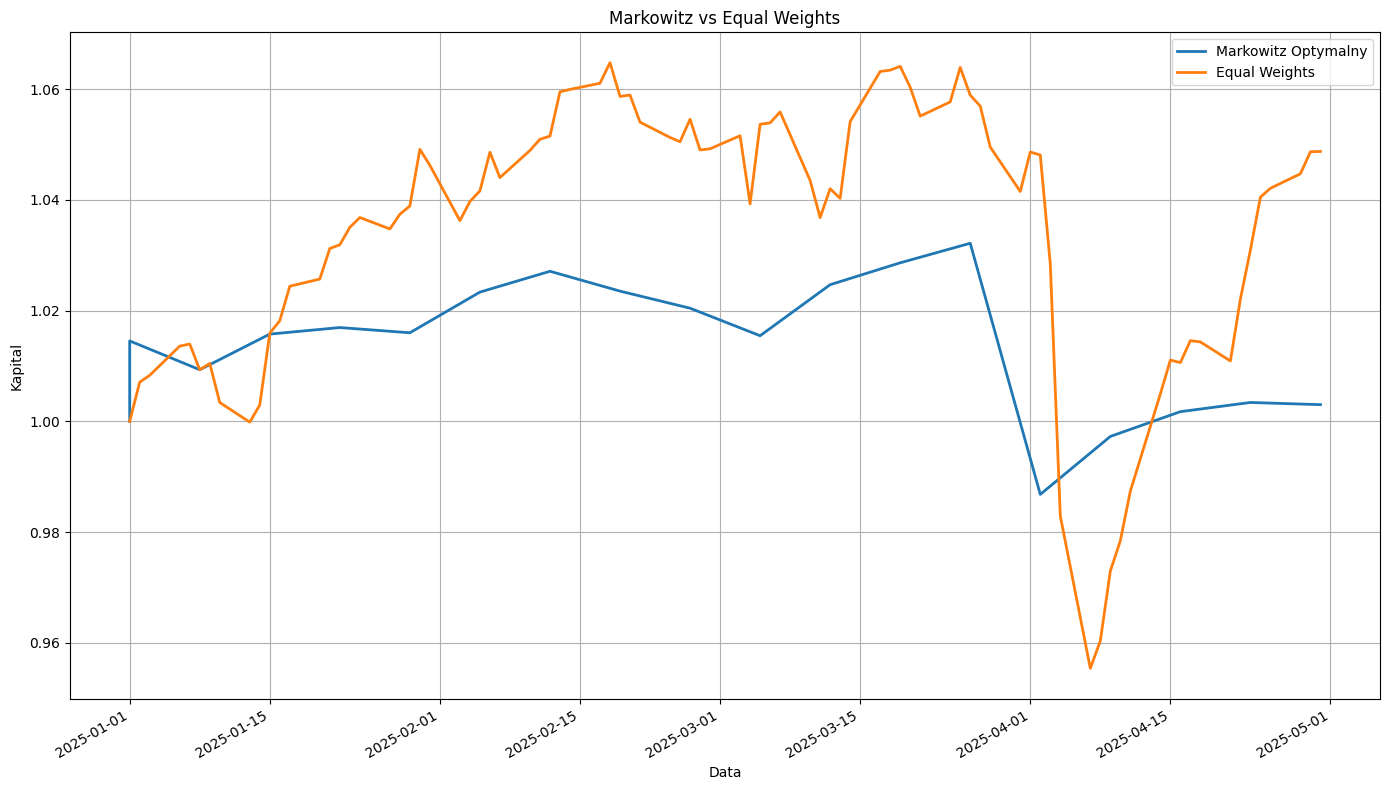

Statystyki Markowitz:
  Zwrot roczny (CAGR): 0.0093
  sredni zwrot: 0.0605
  Zmienność roczna: 0.1951
  Sharpe Ratio: 0.3102
  Max Drawdown: -0.0440
Statystyki Equal Weights:
  Zwrot roczny (CAGR): 0.1574
  sredni zwrot: 0.1503
  Zmienność roczna: 0.1346
  Sharpe Ratio: 1.1164
  Max Drawdown: -0.1028
koszty transakcyjne Markowitz: 0.0170
koszty transakcyjne Equal Weights: 0.0000


In [5]:

data_dir  = r"C:\Users\Basia\Do przejrzenia\am_sem2\mgr\kody\downloaded_data"
df_all = load_data(data_dir, sample_n=771)
pivoted = prepare_pivot(df_all)

# Markowitz
df_capital_mkv, total_cost_mkv = rolling_markowitz(
    pivoted_prices=pivoted,
    window_days=60,
    fee_rate=0.001,
    rebalance_period=5,
    target_return=0.001
)

# Equal Weights
df_capital_eq, total_cost_eq = rolling_equal(
    pivoted_prices=pivoted,
    rebalance_period=5,
    fee_rate=0.001
)

stats_mkv = calculate_portfolio_stats(df_capital_mkv)
stats_eq = calculate_portfolio_stats(df_capital_eq)


plt.figure(figsize=(14, 8))
df_capital_mkv.plot(label="Markowitz Optymalny", linewidth=2)
df_capital_eq.plot(label="Equal Weights", linewidth=2)
plt.title("Markowitz vs Equal Weights")
plt.xlabel("Data")
plt.ylabel("Kapital")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#
print("Statystyki Markowitz:")
for k, v in stats_mkv.items():
    print(f"  {k}: {v:.4f}")

print("Statystyki Equal Weights:")
for k, v in stats_eq.items():
    print(f"  {k}: {v:.4f}")

print(f"koszty transakcyjne Markowitz: {total_cost_mkv:.4f}")
print(f"koszty transakcyjne Equal Weights: {total_cost_eq:.4f}")


In [4]:
returns_test = pivoted.pct_change().dropna()
returns_2025 = returns_test[returns_test.index.year == 2025]
print("Średni dzienny zwrot w 2025:", returns_2025.mean().mean())
print("Liczba dni ze średnim zwrotem > 0:", (returns_2025.mean(axis=1) > 0).sum())


Średni dzienny zwrot w 2025: 0.002710735037801025
Liczba dni ze średnim zwrotem > 0: 55
